In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.percentile_portfolio import *

from factor_mining.attribution.factor_correlation import *

from factor_mining.Mark0 import * # This is alpha file

In [5]:
# class BackTestSinglePeriod(object):
# 	# This serves as an abstract base class
# 	# Each strategy should have its own version of single period backtest caclculator derived from this class

# 	def get_config(self):
# 		assert False

# 	def get_func_name(self):
# 		assert False

# 	def calc_pnl(self, univ, factor_exp_mat, t, **kwargs):
# 		assert False
        
# class BackTest(object):
# 	def __init__(self, univ:dict, factor_exp_mat:dict, daterange:list, sp_calc:BackTestSinglePeriod, rebal=1):
# 		self.univ = univ
# 		self.factor_exp_mat = factor_exp_mat
# 		self.dstart, self.dend = np.min(daterange), np.max(daterange)
# 		self.rebal = rebal
# 		self.sp_calc = sp_calc
# 		self.has_pnl, self.has_pa = False, False

# 	def get_config(self):
# 		config = {}
# 		config['Strategy Name'] = self.sp_calc.get_func_name()
# 		config['Strategy config'] = self.sp_calc.get_config()
# 		config['Date range'] = [self.dstart.strftime('%Y-%m-%d'), self.dend.strftime('%Y-%m-%d')]
# 		config['Rebalance period'] = self.rebal

# 		if self.has_pnl:
# 			pass
		
# 		if self.has_pa:
# 			pass

# 		return config

# 	def calc_pnl(self, **kwargs):
# 		datelst = sorted(self.univ.keys())
# 		tin_lst, ptfl_lst, pnl_lst = [], [], []
# 		count = 0
# 		for t in datelst:
# 			if t < self.dstart or t > self.dend:
# 				continue

# 			if count == 0:
# 				ptfl_sp, pnl_sp = self.sp_calc.calc_pnl(self.univ, self.factor_exp_mat, t, **kwargs)
# 			else:
# 				ret_name = 'f_log_ret_1'
# 				op_na = pd.merge(ptfl_sp, univ[t], on='ticker', how='inner') # This stands for old portfolio, new analytics
# 				pnl_sp = np.dot(op_na['weight'], op_na[ret_name])

# 			tin_lst.append(t)
# 			ptfl_lst.append(ptfl_sp.copy())
# 			pnl_lst.append(pnl_sp)

# 			count -= 1
# 			count %= self.rebal

# 		self.pnl_lst = pd.DataFrame({'date':tin_lst, 'pnl':pnl_lst})
# 		self.ptfl_lst = ptfl_lst
# 		self.has_pnl = True
# 		return ptfl_lst, pnl_lst

# 	def simple_pa(self, **kwargs):
# 		self.pa = simple_pa(self.pnl_lst)
# 		self.has_pa = True
        
# class PercentilePtflSpcalc(BackTestSinglePeriod):
# 	def __init__(self, signal, sel_range, weighting='market_cap'):
# 		self.signal = signal
# 		self.sel_range = sel_range
# 		self.weighting = weighting

# 	def get_config(self):
# 		config = {}
# 		config['Signal variable'] = self.signal
# 		config['Selection range'] = self.sel_range
# 		config['Weighting'] = self.weighting
# 		return config

# 	def get_func_name(self):
# 		return 'Percentile Portfolio'

# 	def calc_pnl(self, univ, factor_exp_mat, t, **kwargs):
# 		ret_name = 'f_log_ret_1'
# 		univ_sp, factor_exp_mat_sp = univ[t].copy(), factor_exp_mat[t].copy()
# 		if 'demean' in kwargs:
# 			if kwargs['demean'] == 'industry':
# 				demean = kwargs['demean']
# 				univ_sp['f_log_ret_1_demean'] = univ_sp[ret_name] - univ_sp.groupby(demean)[ret_name].transform('mean')           
# 				ret_name = 'f_log_ret_1_demean'

# 		pct_low, pct_high = np.min(self.sel_range), np.max(self.sel_range)
# 		signal_var = np.asarray(factor_exp_mat_sp[self.signal])
# 		cutoff_low, cutoff_high = np.percentile(signal_var[~np.isnan(signal_var)], [pct_low, pct_high])
# 		ix_in = (signal_var >= cutoff_low) * (signal_var <= cutoff_high)
# 		ticker_in = factor_exp_mat_sp['ticker'][ix_in]

# 		ptfl = univ_sp.loc[univ_sp['ticker'].isin(ticker_in), :]
# 		if self.weighting == 'market_cap':
# 			ptfl['weight'] = ptfl['market_cap']
# 		elif self.weighting == 'equal':
# 			ptfl['weight'] = [1] * len(ptfl.index)
# 		else:
# 			raise('unknown weighting method', self.weighting)

# 		ptfl['weight'] = ptfl['weight'] / np.nansum(ptfl['weight']) # normalize to 1
# 		pnl_sp = np.dot(ptfl['weight'], ptfl[ret_name])
# 		ptfl_sp = ptfl[['date', 'ticker', 'weight']]
# 		return ptfl_sp, pnl_sp

In [6]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary file')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v4.csv'
    univ = univ_setup(big_table_dir)
    # filt_by_name(univ) # This is slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

filt_na(univ)
import warnings
warnings.filterwarnings("ignore")

### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])
print('Done')

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Setup R3000 universe
use existing binary file
0.378247 seconds
Calculate factors
Filt the untradables
Done
Scale each factor
Winsorize with +/- 3 std
Done


In [14]:
datelst = sorted(univ.keys())
# crdf = factor_correlation(univ, factor_exp_mat, lag = 0, demean='industry')

In [8]:
# factor_correlation_plot(crdf, ma=12)

In [12]:
spcalc = PercentilePtflSpcalc(signal='beta', sel_range=[80, 100])
bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[datetime(2014, 1, 1), datetime(2016, 12, 31)], sp_calc=spcalc, rebal=4)
ptfl_lst, pnl_lst = bt.calc_pnl()

In [17]:
from itertools import product
rebal = [1]
# factor_names = factor_exp_mat[datelst[0]].columns[2:].tolist()
factor_names = ['log_market_cap']
step = 5
ranges = [[i * step, (i + 1) * step] for i in range(100//step)]
daterange = [datetime(2014, 1, 1), datetime(2016, 12, 31)]
config_iter = product(rebal, factor_names, ranges)
iter_result = {}
for r, f, g in config_iter:
#     print(r,f,g)
    spcalc = PercentilePtflSpcalc(signal=f, sel_range=g, weighting='equal')
    bt = BackTest(univ, factor_exp_mat, daterange, spcalc, rebal=r)
    ptfl_lst, pnl_lst = bt.calc_pnl(demean='industry')
    k = f + '_' + str(g[0]) + '_' + str(g[1]) + '_' + str(r)
    iter_result[k] = (np.nanmean(pnl_lst), np.sqrt(np.nanvar(pnl_lst)))

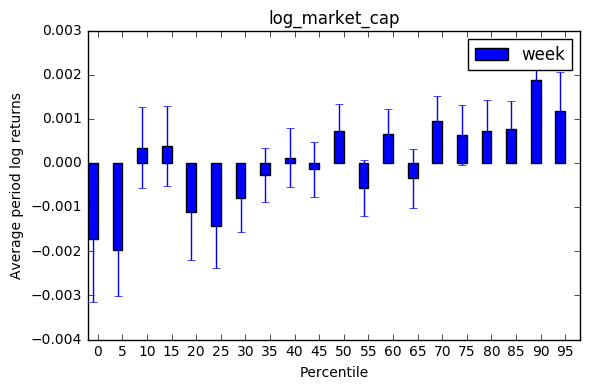

In [19]:
for n in factor_names:
# n = 'log_market_cap'
    c = len(pnl_lst)
    x = [5*i for i in range(20)]
    y_1 = [iter_result[n+'_'+str(i)+'_'+str(i+5)+'_1'][0] for i in x]
    s_1 = [iter_result[n+'_'+str(i)+'_'+str(i+5)+'_1'][1] / np.sqrt(c) for i in x]
#     y_4 = [iter_result[n+'_'+str(i)+'_'+str(i+5)+'_4'][0] for i in x]
#     s_4 = [iter_result[n+'_'+str(i)+'_'+str(i+5)+'_4'][1] / np.sqrt(c) for i in x]
    
    # Here comes the plots
    bar_width = 2
    week = plt.bar(np.array(x), y_1, width=bar_width, yerr=s_1, color='b', label='week')
#     month = plt.bar(np.array(x) + bar_width, y_4, width=bar_width, yerr=s_4, color='g', label='month')

    plt.xlabel('Percentile')
    plt.ylabel('Average period log returns')
    plt.title(n)
    plt.xticks(np.array(x) + bar_width, x)
    plt.legend()

    plt.tight_layout()
    plt.show()